In [1]:
pip install kagglehub matplotlib seaborn torchmetrics scikit-learn grad_cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 13.6 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.9/101.9 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 18.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 81.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jonathansilva2020/orange-diseases-dataset")
print("Path to dataset files:", path)

100%|██████████| 138M/138M [00:04<00:00, 31.5MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jonathansilva2020/orange-diseases-dataset/versions/3


In [3]:
import os

print(os.listdir(path = path))
print(os.listdir(path = path + "/train"))
print(os.listdir(path = path + "/test"))
train_path = path + "/train"
test_path = path + "/test"

['test', 'train']
['blackspot', 'canker', 'fresh', 'grenning']
['blackspot', 'canker', 'fresh', 'grenning']


In [4]:
# train 경로에 있는 폴더 내의 이미지 파일 불러오기
categories = os.listdir(path = path + "/train")

# Create a dictionary to hold the path to one image from each category
image_paths = {}

def get_image_from_path(dataset_dir, category):
  for category in categories:
      category_dir = os.path.join(dataset_dir, category)
      # List all files in the category directory
      files = os.listdir(category_dir)
      # Select the first image file (assuming there is at least one image in each category)
      if files:
          image_paths[category] = os.path.join(category_dir, files[0])
  return image_paths

image_paths = get_image_from_path(train_path, categories)

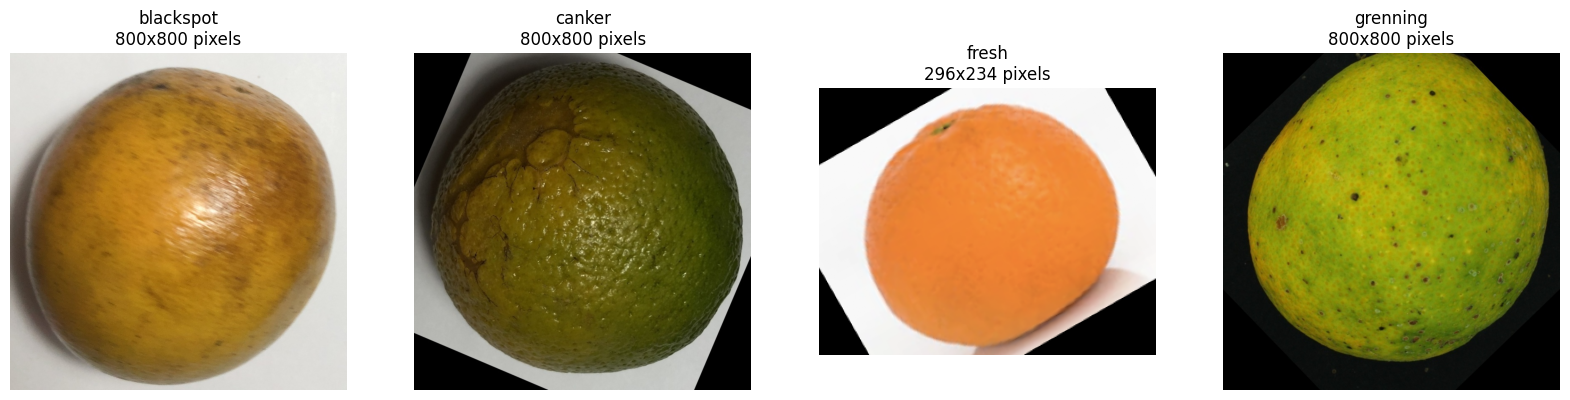

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_images(image_paths):
  # Set up the plot
  fig, axes = plt.subplots(1, 4, figsize=(20, 5))

  # Loop through each category and display the image
  for ax, (category, image_path) in zip(axes, image_paths.items()):
      # Load the image
      image = mpimg.imread(image_path)
      # Get image dimensions
      height, width, _ = image.shape
      # Display the image
      ax.imshow(image)
      ax.set_title(f'{category}\n{width}x{height} pixels')
      ax.axis('off')  # Turn off the axis

  # Show the plot
  plt.show()

show_images(image_paths)

In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CustomImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        if not (path.endswith(".jpg") or path.endswith(".png")):
            return None
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target

In [7]:
import torchvision.models as models

model_s = models.efficientnet_v2_s(weights = models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
model_m = models.efficientnet_v2_m(weights = models.EfficientNet_V2_M_Weights.IMAGENET1K_V1)
model_l = models.efficientnet_v2_l(weights = models.EfficientNet_V2_L_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 185MB/s] 
Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100%|██████████| 208M/208M [00:04<00:00, 46.6MB/s] 
Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:02<00:00, 160MB/s]  


In [8]:
criterion = nn.CrossEntropyLoss()

In [9]:
from torch.utils.data import Dataset, DataLoader

model_s_weights = models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
model_m_weights = models.EfficientNet_V2_M_Weights.IMAGENET1K_V1
model_l_weights = models.EfficientNet_V2_L_Weights.IMAGENET1K_V1

print(model_s_weights.transforms())
print(model_m_weights.transforms())
print(model_l_weights.transforms())

train_dir = "/root/.cache/kagglehub/datasets/jonathansilva2020/orange-diseases-dataset/versions/3/train"
test_dir = "/root/.cache/kagglehub/datasets/jonathansilva2020/orange-diseases-dataset/versions/3/test"

train_dataset_model_s = CustomImageFolder(train_path, transform=model_s_weights.transforms())
train_dataset_model_m = CustomImageFolder(train_path, transform=model_m_weights.transforms())
train_dataset_model_l = CustomImageFolder(train_path, transform=model_l_weights.transforms())

test_dataset_model_s = CustomImageFolder(test_path, transform=model_s_weights.transforms())
test_dataset_model_m = CustomImageFolder(test_path, transform=model_m_weights.transforms())
test_dataset_model_l = CustomImageFolder(test_path, transform=model_l_weights.transforms())

model_s = models.efficientnet_v2_s(weights = models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
model_m = models.efficientnet_v2_m(weights = models.EfficientNet_V2_M_Weights.IMAGENET1K_V1)
model_l = models.efficientnet_v2_l(weights = models.EfficientNet_V2_L_Weights.IMAGENET1K_V1)

from torch.utils.data import random_split

# 모델별 weights와 datasets을 dict로 정리
model_weights = {
    "s": model_s_weights,
    "m": model_m_weights,
    "l": model_l_weights
}

train_datasets = {
    "s": train_dataset_model_s,
    "m": train_dataset_model_m,
    "l": train_dataset_model_l
}

# 결과 저장용 dict
train_loaders = {}
val_loaders = {}

# 공통 설정
val_ratio = 0.2
batch_size = 32
seed = 42

for key in ["s", "m", "l"]:
    dataset = train_datasets[key]
    weight = model_weights[key]

    val_size = int(len(dataset) * val_ratio)
    train_size = len(dataset) - val_size

    train_subset, val_subset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

    # transform 다시 지정
    train_subset.dataset.transform = weight.transforms()
    val_subset.dataset.transform = weight.transforms()

    # DataLoader 만들기
    train_loaders[key] = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loaders[key] = DataLoader(val_subset, batch_size=batch_size, shuffle=False)


ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
ImageClassification(
    crop_size=[480]
    resize_size=[480]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
ImageClassification(
    crop_size=[480]
    resize_size=[480]
    mean=[0.5, 0.5, 0.5]
    std=[0.5, 0.5, 0.5]
    interpolation=InterpolationMode.BICUBIC
)


In [10]:
from torch.utils.data import random_split
from tqdm import tqdm

# 모델별 weights와 datasets을 dict로 정리
model_weights = {
    "s": model_s_weights,
    "m": model_m_weights,
    "l": model_l_weights
}

train_datasets = {
    "s": train_dataset_model_s,
    "m": train_dataset_model_m,
    "l": train_dataset_model_l
}

# 결과 저장용 dict
train_loaders = {}
val_loaders = {}

# 공통 설정
val_ratio = 0.2
batch_size = 32
seed = 42

for key in ["s", "m", "l"]:
    dataset = train_datasets[key]
    weight = model_weights[key]

    val_size = int(len(dataset) * val_ratio)
    train_size = len(dataset) - val_size

    train_subset, val_subset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

    # transform 다시 지정
    train_subset.dataset.transform = weight.transforms()
    val_subset.dataset.transform = weight.transforms()

    # DataLoader 만들기
    train_loaders[key] = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loaders[key] = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

test_dataset_model_s = CustomImageFolder(test_path, transform=model_s_weights.transforms())
test_dataset_model_m = CustomImageFolder(test_path, transform=model_m_weights.transforms())
test_dataset_model_l = CustomImageFolder(test_path, transform=model_l_weights.transforms())

test_loader_model_s = DataLoader(test_dataset_model_s, batch_size= 32)
test_loader_model_m = DataLoader(test_dataset_model_m, batch_size= 32)
test_loader_model_l = DataLoader(test_dataset_model_l, batch_size= 32)

model_s.classifier[-1] = nn.Linear(1280, len(train_dataset_model_s.classes))
model_m.classifier[-1] = nn.Linear(1280, len(train_dataset_model_m.classes))
model_l.classifier[-1] = nn.Linear(1280, len(train_dataset_model_l.classes))

In [11]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=10, model_name="", num_classes=None):
    model.to(device)

    # 로그 저장용 리스트
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    val_f1_list = []

    f1_metric = F1Score(task="multiclass", num_classes=num_classes, average="macro").to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"[{model_name}] Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        avg_train_loss = running_loss / len(train_loader)

        # === 검증 ===
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss_total = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss_total += loss.item()
                preds = torch.argmax(outputs, dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

                all_preds.append(preds)
                all_labels.append(labels)

        val_acc = val_correct / val_total
        avg_val_loss = val_loss_total / len(val_loader)

        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        val_f1 = f1_metric(all_preds, all_labels).item()


        # 리스트에 저장
        train_loss_list.append(avg_train_loss)
        val_loss_list.append(avg_val_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        val_f1_list.append(val_f1)

        print(f"[{model_name}] Epoch {epoch+1} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc*100:.2f}% | F1: {val_f1:.4f}\n")

    # === 최종 시각화 ===
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(16, 5))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss_list, label='Train Loss')
    plt.plot(epochs, val_loss_list, label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_acc_list, label='Train Acc')
    plt.plot(epochs, val_acc_list, label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # F1 Score
    plt.subplot(1, 3, 3)
    plt.plot(epochs, val_f1_list, label='Val F1 Score', color='green')
    plt.title(f'{model_name} F1 Score')
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 🔹 시각화를 위한 헬퍼 함수
def plot_confusion_matrix(preds, labels, class_names, normalize=False):
    cm = confusion_matrix(labels.cpu(), preds.cpu(), normalize='true' if normalize else None)
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", 
                cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')
    plt.tight_layout()
    return fig

# 🔹 평가 함수
def evaluate_model(model, dataloader, num_classes, device, model_name=""):
    model.eval()
    accuracy = Accuracy(task="multiclass", num_classes=num_classes).to(device)
    f1 = F1Score(task="multiclass", num_classes=num_classes, average="macro").to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"Evaluating {model_name}"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds)
            all_labels.append(labels)

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    acc_value = accuracy(all_preds, all_labels).item()
    f1_value = f1(all_preds, all_labels).item()

    print(f"[{model_name}] Test Accuracy: {acc_value * 100:.2f}% | F1 Score: {f1_value:.4f}")

    # ✅ 고정된 클래스 이름으로 confusion matrix 시각화
    class_names = ['blackspot', 'canker', 'fresh', 'grenning']
    fig = plot_confusion_matrix(all_preds, all_labels, class_names, normalize=True)
    plt.title(f"Confusion Matrix_{model_name}")
    plt.show()

    return acc_value, f1_value

In [13]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from PIL import Image

CLASS_NAMES = ['blackspot', 'canker', 'fresh', 'grenning']

def get_mean_std_from_weights(weights):
    return np.array(weights.transforms().mean), np.array(weights.transforms().std)

def visualize_gradcam_by_class(model, test_dataset, weights, device='cuda'):
    model.eval()
    model.to(device)

    mean, std = get_mean_std_from_weights(weights)
    target_layer = model.features[-1][0]
    cam = GradCAM(model=model, target_layers=[target_layer], device=device)

    cam_images = []  # CAM 이미지들을 저장할 리스트
    titles = []      # 클래스 이름 저장용

    for class_idx, class_name in enumerate(CLASS_NAMES):
        for image, label in test_dataset:
            if label == class_idx:
                input_tensor = image.unsqueeze(0).to(device)
                targets = [ClassifierOutputTarget(class_idx)]
                grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

                rgb_image = image.permute(1, 2, 0).cpu().numpy()
                rgb_image = np.clip((rgb_image * std) + mean, 0, 1)
                cam_image = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

                cam_images.append(cam_image)
                titles.append(class_name)
                break  # 다음 클래스로 넘어감

    # === 가로 시각화 ===
    num_classes = len(cam_images)
    fig, axs = plt.subplots(1, num_classes, figsize=(5 * num_classes, 5))

    for i in range(num_classes):
        axs[i].imshow(cam_images[i])
        axs[i].axis('off')
        axs[i].set_title(f"Class: {titles[i]}", fontsize=14)

    plt.tight_layout()
    plt.show()

Evaluating EfficientNetV2-S: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


[EfficientNetV2-S] Test Accuracy: 32.32% | F1 Score: 0.3127


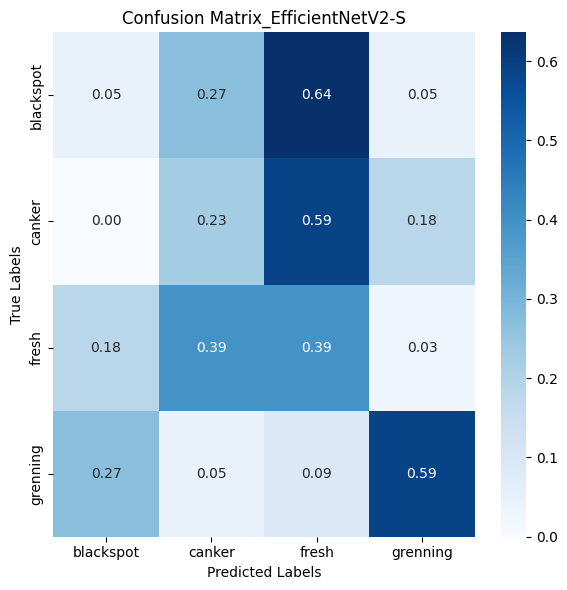

Evaluating EfficientNetV2-M: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]

[EfficientNetV2-M] Test Accuracy: 23.23% | F1 Score: 0.1258


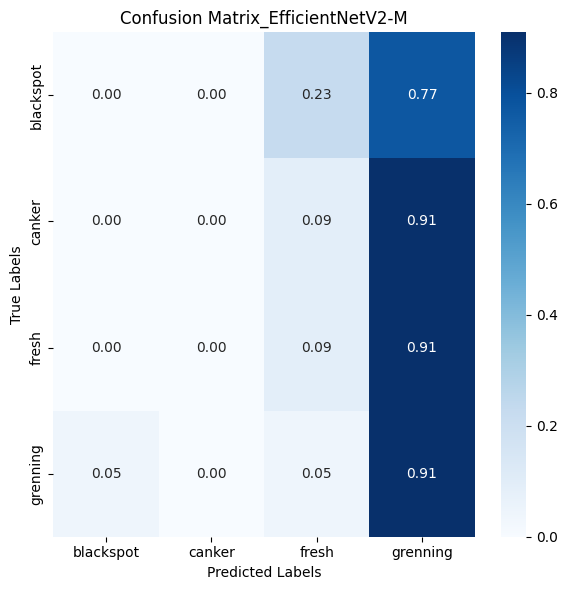

Evaluating EfficientNetV2-L: 100%|██████████| 4/4 [00:06<00:00,  1.51s/it]

[EfficientNetV2-L] Test Accuracy: 21.21% | F1 Score: 0.1267


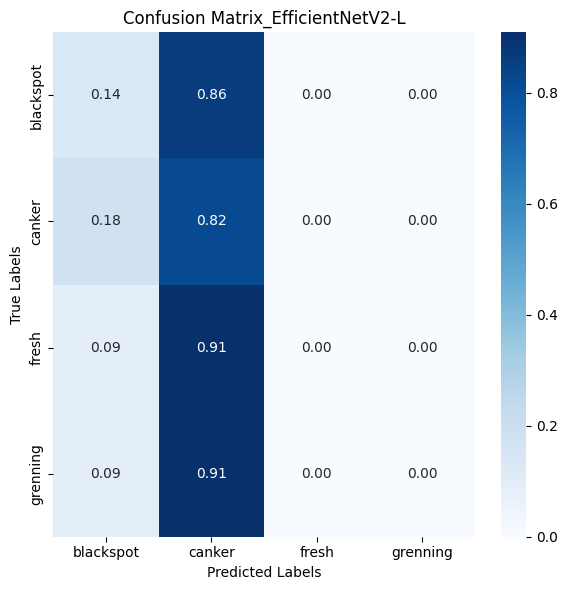

In [17]:
from torchmetrics.classification import Accuracy, F1Score

NUM_CLASSES = len(train_dataset_model_s.classes)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_s = model_s.to(device)
model_m = model_m.to(device)
model_l = model_l.to(device)

class_names = train_dataset_model_s.classes  # ImageFolder 기반이면 클래스 순서 자동 포함




acc_s, f1_s = evaluate_model(model = model_s, dataloader=test_loader_model_s, num_classes=NUM_CLASSES, device=device, model_name="EfficientNetV2-S")
acc_m, f1_m = evaluate_model(model_m, test_loader_model_m, NUM_CLASSES, device, model_name = "EfficientNetV2-M")
acc_l, f1_l = evaluate_model(model_l, test_loader_model_l, NUM_CLASSES, device, model_name = "EfficientNetV2-L")

[EfficientNetV2-S] Epoch 1/10: 100%|██████████| 25/25 [00:17<00:00,  1.45it/s]


[EfficientNetV2-S] Epoch 1 | Train Loss: 0.4933 | Train Acc: 91.05% | Val Loss: 0.0648 | Val Acc: 98.99% | F1: 0.9876



[EfficientNetV2-S] Epoch 2/10: 100%|██████████| 25/25 [00:16<00:00,  1.51it/s]


[EfficientNetV2-S] Epoch 2 | Train Loss: 0.0541 | Train Acc: 98.87% | Val Loss: 0.0724 | Val Acc: 97.47% | F1: 0.9690



[EfficientNetV2-S] Epoch 3/10: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s]


[EfficientNetV2-S] Epoch 3 | Train Loss: 0.0246 | Train Acc: 99.50% | Val Loss: 0.1388 | Val Acc: 95.96% | F1: 0.9500



[EfficientNetV2-S] Epoch 4/10: 100%|██████████| 25/25 [00:16<00:00,  1.51it/s]


[EfficientNetV2-S] Epoch 4 | Train Loss: 0.0419 | Train Acc: 98.61% | Val Loss: 0.0396 | Val Acc: 98.99% | F1: 0.9876



[EfficientNetV2-S] Epoch 5/10: 100%|██████████| 25/25 [00:15<00:00,  1.58it/s]


[EfficientNetV2-S] Epoch 5 | Train Loss: 0.0155 | Train Acc: 99.75% | Val Loss: 0.0408 | Val Acc: 98.99% | F1: 0.9877



[EfficientNetV2-S] Epoch 6/10: 100%|██████████| 25/25 [00:16<00:00,  1.55it/s]


[EfficientNetV2-S] Epoch 6 | Train Loss: 0.0121 | Train Acc: 99.87% | Val Loss: 0.0573 | Val Acc: 98.48% | F1: 0.9814



[EfficientNetV2-S] Epoch 7/10: 100%|██████████| 25/25 [00:16<00:00,  1.50it/s]


[EfficientNetV2-S] Epoch 7 | Train Loss: 0.0070 | Train Acc: 99.87% | Val Loss: 0.0371 | Val Acc: 98.48% | F1: 0.9815



[EfficientNetV2-S] Epoch 8/10: 100%|██████████| 25/25 [00:16<00:00,  1.52it/s]


[EfficientNetV2-S] Epoch 8 | Train Loss: 0.0071 | Train Acc: 99.87% | Val Loss: 0.0999 | Val Acc: 97.98% | F1: 0.9752



[EfficientNetV2-S] Epoch 9/10: 100%|██████████| 25/25 [00:16<00:00,  1.53it/s]


[EfficientNetV2-S] Epoch 9 | Train Loss: 0.0069 | Train Acc: 100.00% | Val Loss: 0.0175 | Val Acc: 98.99% | F1: 0.9877



[EfficientNetV2-S] Epoch 10/10: 100%|██████████| 25/25 [00:16<00:00,  1.52it/s]


[EfficientNetV2-S] Epoch 10 | Train Loss: 0.0143 | Train Acc: 99.50% | Val Loss: 0.0279 | Val Acc: 98.48% | F1: 0.9815



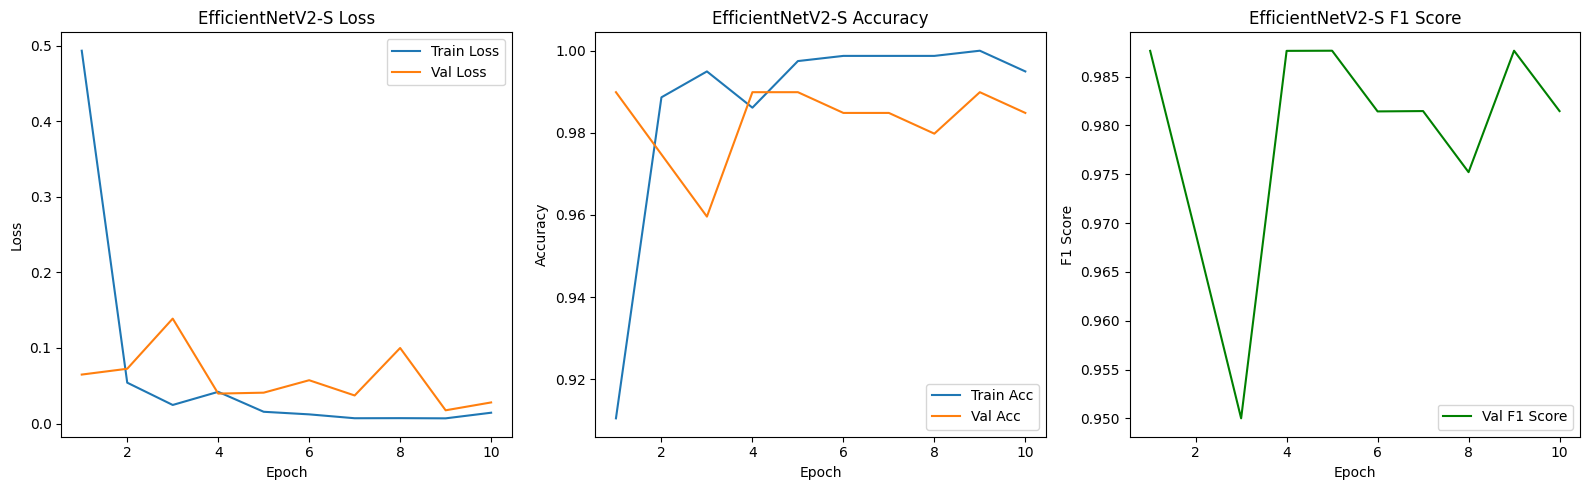

In [16]:
EPOCHS = 10
criterion = torch.nn.CrossEntropyLoss()
optimizer_s = torch.optim.Adam(model_s.parameters(), lr=1e-4)



train_model(
    model=model_s,
    train_loader=train_loaders["s"],
    val_loader=val_loaders["s"],
    optimizer=optimizer_s,
    criterion=criterion,
    device=device,
    num_epochs=10,
    model_name="EfficientNetV2-S",
    num_classes=NUM_CLASSES
)

Evaluating EfficientNetV2-S: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]

[EfficientNetV2-S] Test Accuracy: 98.99% | F1 Score: 0.9886


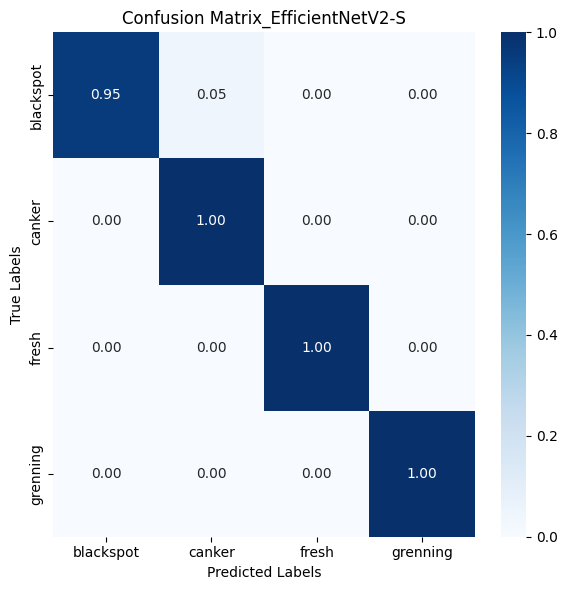

(0.9898989796638489, 0.988630473613739)

In [64]:
evaluate_model(model = model_s, dataloader=test_loader_model_s, num_classes=NUM_CLASSES, device=device, model_name="EfficientNetV2-S")

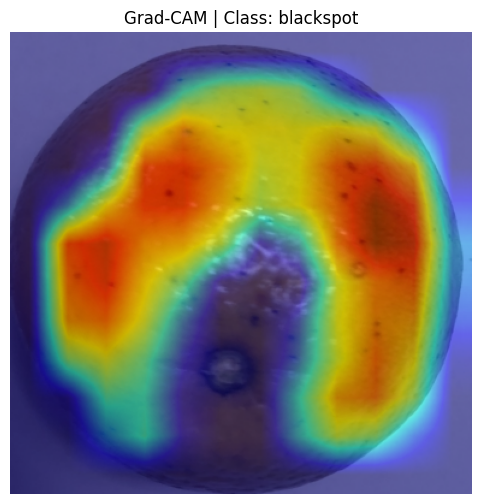

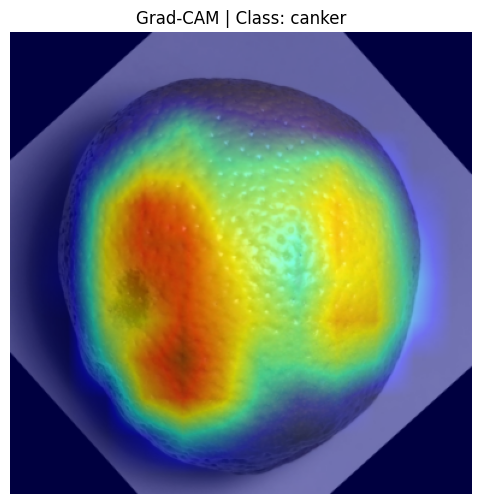

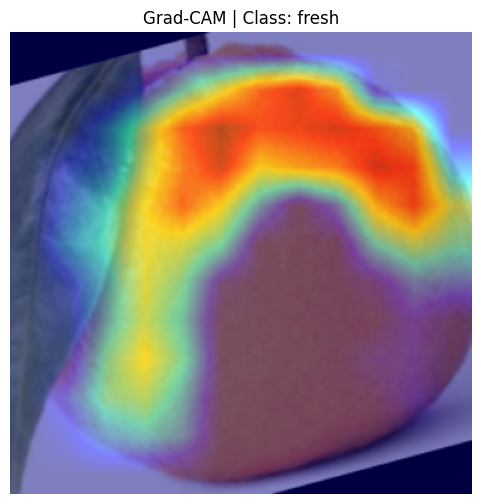

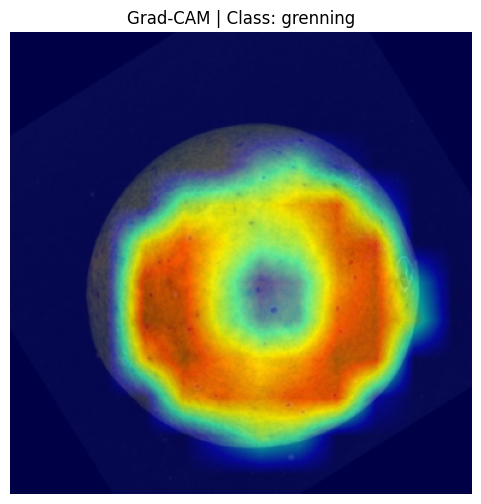

In [86]:
visualize_gradcam_by_class(
    model=model_s,
    test_dataset=test_dataset_model_s,
    weights=model_weights["s"],
    device=device
)



In [20]:
optimizer_m = torch.optim.Adam(model_m.parameters(), lr=1e-4)

train_model(
    model=model_m,
    train_loader=train_loaders["m"],
    val_loader=val_loaders["m"],
    optimizer=optimizer_m,
    criterion=criterion,
    device=device,
    num_epochs=10,
    model_name="EfficientNetV2-S",
    num_classes=NUM_CLASSES
)

In [ ]:
evaluate_model(model = model_m, dataloader=test_loader_model_m, num_classes=NUM_CLASSES, device=device, model_name="EfficientNetV2-M")

In [ ]:
visualize_gradcam_by_class(
    model=model_m,
    test_dataset=test_dataset_model_m,
    weights=model_weights["m"],
    device=device
)

In [ ]:
# optimizer_l = torch.optim.Adam(model_l.parameters(), lr=1e-4)

# train_model(
#     model=model_l,
#     train_loader=train_loaders["l"],
#     val_loader=val_loaders["l"],
#     optimizer=optimizer_l,
#     criterion=criterion,
#     device=device,
#     num_epochs=10,
#     model_name="EfficientNetV2-L",
#     num_classes=NUM_CLASSES
# )

In [ ]:
evaluate_model(model = model_l, dataloader=test_loader_model_l, num_classes=NUM_CLASSES, device=device, model_name="EfficientNetV2-L")